# Building an Adaptive RAG System with LangGraph

This project will cover a full hands-on workflow and demonstration of how to build an Agentic Adaptive RAG System with LangGraph

The idea would be to implement the workflow taking inspiration from the [Adaptive-RAG](https://arxiv.org/pdf/2403.14403) research paper.

The main challenge of RAG systems include:

- Poor Retrieval can lead to issues in LLM response generation
- Bad retrieval or lack of information in the vector database can also lead to out of context or hallucinated answers
- Even complex RAG Systems like CRAG suffer from the fact that they are fixed flows which will always be executed regardless of query complexity

The idea is to build a dynamic agentic RAG system which can adapt based on the input query and route it to the best possible RAG workflow to handle it. In our case we will take a user query and route it either to be handled by the:
- Web Search based RAG Flow
- Vector DB based RAG flow

We will also add in elements of Corrective RAG and Self-Reflective RAG here.

We can build this as an agentic RAG system by having a specific functionality step as a node in the graph and use LangGraph to implement it. Key steps in the node will include prompts being sent to LLMs, tools, DBs to perform specific tasks as seen in the detailed workflow below:

![](https://i.imgur.com/ESG2Jc7.png)



### Adaptive RAG System with LangGraph

This project implements an **Adaptive RAG System** using LangGraph, designed to dynamically route user queries through the most suitable Retrieval-Augmented Generation (RAG) workflow. It supports both **Vector DB-based** and **Web Search-based** retrieval paths and incorporates elements from **Corrective RAG** (document grading) and **Self-Reflective RAG** (hallucination detection and feedback correction).

The adaptive workflow includes the following key components:

1. **Dynamic Query Routing**:
   - A **Query Router Prompt** classifies the user query and decides whether the information should be retrieved from:
     - An internal **Vector Database**, or
     - A **Web Search** engine.
   - Based on the routing decision, the query is rephrased using:
     - **VectorDB Rephrase Prompt** for vector-optimized semantic search, or
     - **Web Search Rephrase Prompt** for better recall from web sources.

2. **Retrieval and Context Preparation**:
   - **If the source is Vector DB**:
     - Rephrased query is used to retrieve documents from the **Vector Database**.
     - Retrieved documents are passed through an **LLM Grader Prompt**, which filters relevant documents using semantic grading (`yes` or `no`).
     - If **more than 50%** of documents are relevant, they are forwarded to the next stage.
     - If **50% or fewer** documents are relevant, the system switches to the **Web Search** path.
     - Any irrelevant documents are removed.

   - **If the source is Web Search** (or >=50% docs irrelevant from Vector DB route):
     - The rephrased query is used directly to search the web and retrieve external context documents.

3. **Answer Generation (RAG Prompt)**:
   - Final relevant documents — either from the Vector DB (filtered) and / or Web Search (raw) — are used in the **RAG Prompt**.
   - The prompt instructs the LLM to answer only using the provided context.
   - If feedback exists (from a prior iteration in case there were hallucinations), it is also included in the prompt to improve the response.

4. **Self-Reflective Hallucination Check**:
   - The generated answer undergoes evaluation using a **Hallucination Check Prompt**.
   - The LLM checks if the answer is grounded in the context documents and returns:
     - A **hallucination flag** (`yes` or `no`)
     - Optional **feedback** explaining the judgment.

5. **Feedback Loop for Regeneration**:
   - If the hallucination flag is `no`, the answer is finalized.
   - If it is `yes`, the feedback is used to regenerate the response using the same context via the **RAG Prompt**, making the system more reliable and self-correcting.

This **Adaptive RAG System** combines adaptive routing, corrective RAG, and self-reflective RAG elements to produce accurate, high-quality answers.

___Created By: [Dipanjan (DJ)](https://www.linkedin.com/in/dipanjans/)___

## Install OpenAI, Tavily, LangGraph and LangChain dependencies


In [1]:
!pip install langchain==0.3.20
!pip install langchain-openai==0.3.9
!pip install langchain-community==0.3.20
!pip install langgraph==0.3.18
!pip install langchain-tavily==0.1.5

  Using cached langchain-0.3.20-py3-none-any.whl.metadata (7.7 kB)
Using cached langchain-0.3.20-py3-none-any.whl (1.0 MB)
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.27
    Uninstalling langchain-0.3.27:
      Successfully uninstalled langchain-0.3.27


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-community 0.3.20 requires langchain<1.0.0,>=0.3.21, but you have langchain 0.3.20 which is incompatible.


  Using cached langchain-0.3.27-py3-none-any.whl.metadata (7.8 kB)
Using cached langchain-0.3.27-py3-none-any.whl (1.0 MB)
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.20
    Uninstalling langchain-0.3.20:
      Successfully uninstalled langchain-0.3.20


## Install PyMuPDF for loading PDF documents

In [2]:
!pip install pymupdf==1.25.4

## Install ChromaDB LangChain Wrapper for Vector DB

In [3]:
!pip install langchain-chroma==0.2.2

## Enter Open AI API Key

In [4]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

## Enter Tavily Search API Key

Get a free API key from [here](https://tavily.com/#api)

In [5]:
TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

## Setup Environment Variables

In [6]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

## Build a Search Index for Research Paper Data

We will build a vector database for retrieval and search by indexing a few research paper documents, similar to any standard RAG workflows

### Open AI Embedding Models

LangChain enables us to access Open AI embedding models which include the newest models: a smaller and highly efficient `text-embedding-3-small` model, and a larger and more powerful `text-embedding-3-large` model.

In [7]:
from langchain_openai import OpenAIEmbeddings

# details here: https://openai.com/blog/new-embedding-models-and-api-updates
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

### Get the research paper data

In [8]:
# if you can't download using the following code
# go to https://drive.google.com/file/d/1ZOtPmuR-2KpzPvkiQiTVxAyJFo6NszG-/view?usp=sharing download it
# manually upload it on colab

# !gdown 1ZOtPmuR-2KpzPvkiQiTVxAyJFo6NszG-

In [9]:
# !unzip research_papers.zip

### Load and Chunk Documents

We create a directory loader to use a PDF loader (using pymupdf) and load all PDF documents from a given folder

In [10]:
from langchain_community.document_loaders import DirectoryLoader

# Define a function to create a DirectoryLoader for a specific file type
def create_directory_loader(file_type, directory_path, loader_class, loader_args):
    return DirectoryLoader(
        path=directory_path,
        glob=f"**/*{file_type}",
        loader_cls=loader_class,
        loader_kwargs=loader_args,
        show_progress=True
    )

In [11]:
from langchain_community.document_loaders import PyMuPDFLoader

pdf_extn = '.pdf'
pdf_loader_class = PyMuPDFLoader
pdf_loader_args = {} # in case you want to change any settings in pymupdfloader
directory= './research_papers'

pdf_loader = create_directory_loader(file_type=pdf_extn,
                                     directory_path=directory,
                                     loader_class=pdf_loader_class,
                                     loader_args=pdf_loader_args)

# load docs
docs = pdf_loader.load()
len(docs) # PyMuPDF loads every document and breaks it per page by default

100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


62

In [12]:
docs[0]

Document(metadata={'producer': 'PDFium', 'creator': 'PDFium', 'creationdate': 'D:20250321115731', 'source': 'research_papers\\attention.pdf', 'file_path': 'research_papers\\attention.pdf', 'total_pages': 10, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '', 'trapped': '', 'modDate': '', 'creationDate': 'D:20250321115731', 'page': 0}, page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗†\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗‡\nillia.polosukhin@

We then use standard recursive character text chunking

In [13]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Chunk docs
splitter = RecursiveCharacterTextSplitter(chunk_size=4000, chunk_overlap=300)
chunked_docs = splitter.split_documents(docs)

In [14]:
len(chunked_docs)

100

In [15]:
chunked_docs[:3]

[Document(metadata={'producer': 'PDFium', 'creator': 'PDFium', 'creationdate': 'D:20250321115731', 'source': 'research_papers\\attention.pdf', 'file_path': 'research_papers\\attention.pdf', 'total_pages': 10, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '', 'trapped': '', 'modDate': '', 'creationDate': 'D:20250321115731', 'page': 0}, page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗†\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗‡\nillia.polosukhin

### Create a Vector DB and persist on disk

Here we initialize a connection to a Chroma vector DB client, and also we want to save to disk, so we simply initialize the Chroma client and pass the directory where we want the data to be saved to.

In [16]:
from langchain_chroma import Chroma

# create vector DB of docs and embeddings - takes < 30s on Colab
chroma_db = Chroma.from_documents(documents=chunked_docs,
                                  collection_name='rag_db',
                                  embedding=openai_embed_model,
                                  # need to set the distance function to cosine else it uses euclidean by default
                                  # check https://docs.trychroma.com/guides#changing-the-distance-function
                                  collection_metadata={"hnsw:space": "cosine"},
                                  persist_directory="./rag_db")

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


### Setup a Vector Database Retriever

Here we use the following retrieval strategy:

- Similarity with Threshold Retrieval


### Similarity with Threshold Retrieval

We use cosine similarity here and retrieve the top 5 similar documents based on the user input query and also introduce a cutoff to not return any documents which are below a certain similarity threshold

In [17]:
similarity_threshold_retriever = chroma_db.as_retriever(search_type="similarity_score_threshold",
                                                        search_kwargs={"k": 5,
                                                                       "score_threshold": 0.35})

### Test out a few queries

In [18]:
query = "what is PEFT?"
topk_docs = similarity_threshold_retriever.invoke(query)
topk_docs

Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


[Document(id='e63344e3-7bf4-4181-ad96-a3f9b68c9f3e', metadata={'author': '', 'creationDate': 'D:20250321120420', 'creationdate': 'D:20250321120420', 'creator': 'PDFium', 'file_path': 'research_papers\\peft.pdf', 'format': 'PDF 1.7', 'keywords': '', 'modDate': '', 'moddate': '', 'page': 0, 'producer': 'PDFium', 'source': 'research_papers\\peft.pdf', 'subject': '', 'title': '', 'total_pages': 20, 'trapped': ''}, page_content='keeping the rest unaltered. Furthermore, the application of\nPEFT extends beyond the realm of NLP and quickly attracts\ninterest in the CV community for handling fine-tuning vision\nmodels with large parameters, such as Vision Transformers\n(ViT) and diffusion models, as well as disciplinary models\nsuch as vision-language models.\nIn this survey, we systematically review and categorize\nrecent advancements in PEFT algorithms as well as the system\nimplementation costs associated with various PEFT algorithms\nacross diverse scenarios. Figure 1 presents the overview 

Looks like it is getting relevant documents from the vector DB

In [19]:
query = "what are AI Agents?"
topk_docs = similarity_threshold_retriever.invoke(query)
topk_docs

No relevant docs were retrieved using the relevance score threshold 0.35


[]

Whoops seems like there exists no relevant docs for this. The Adaptive RAG System should be able to handle this also

## Create AI Workflows and Tools for Key Components in our Agentic RAG System

There are a few AI workflows (sequential pipelines) and tools we would need to create which we will be using in different steps in our Agentic Adaptive RAG workflow. These include:

- **Query Source Classifier:** This is an essential workflow which can take in a user query, analyze it with an LLM and return the optimal data source which can be used to answer this query - in our case it will either be `vectordb` or `web_search`

- **VectorDB Query Rewriter Workflow:** This is a workflow which uses an LLM to rewrite the given user query (if needed) and make it more optimized for retrieval from a vector database

- **Web Search Query Rewriter Workflow:** This is a workflow which uses an LLM to rewrite the given user query (if needed) and make it more optimized for web search

- **Query Retrieval Grader Workflow:** This is an essential workflow which can take in a user query, a list of retrieved documents from the vector DB and grade each context document as 'yes' or 'no' based on if the document is relevant to the user query or not

- **QA RAG Workflow:** This is a workflow which can take in a user query, list of retrived context documents and use a standard RAG workflow where an LLM uses these context documents to generate a contextual response for the user query

- **Hallucination Checker Workflow:** This is an essential workflow which can take in the RAG generated response from the LLM, the list of context documents and uses an LLM as a judge to check if the generated response is grounded in the facts mentioned in the context documents. If there are any contradictions or hallucinations it grades it as 'yes' or else 'no' and it also creates 'feedback' which contains the reasoning from the LLM judge as to why the grade was 'yes' or 'no'.

- **Web Search Tool:** Build a custom tool which uses the Tavily Search API to search for a user query, get the top web page results and also extract the text content from those web pages

Most of these workflows will be built as LangChain chains (pipelines)

### Create a Query Source Classifier workflow

This is an essential workflow which can take in a user query, analyze it with an LLM and return the optimal data source which can be used to answer this query - in our case it will either be `vectordb` or `web_search`

In [20]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model
class QuerySource(BaseModel):
    """Classify a user query in terms of what datasource should be useful for answering the query."""

    datasource: Literal["vectordb", "web_search"] = Field(
        description="Given a user question classifies it to either web_search or vectordb depending on which source is more useful to answer the query.",
    )


# LLM for classification
llm = ChatOpenAI(model="gpt-4o", temperature=0)
qs_llm_router = llm.with_structured_output(QuerySource)

# Prompt
QS_SYS = """You are an expert at deciding if a user question should be answered using a vector database (vectordb) or by searching the web (web_search).
The vectorstore has documents related to the following topics:
  - Chain of Thought Prompting
  - Transformer Language Model and Attention Mechanisms (self-attention, multi-headed attention etc.)
  - Self supervised vision transformers like the DINO model
  - Diffusion generative models
  - Parameter efficient fine-tuning techniques for language models (PEFT, LoRa, Prompt tuning etc.)

Given the following user query, analyze it carefully and try to see if it is related to any of the above mentioned topics.
Remember to focus on the overall meaning and concepts related to the above topics and not just keywords.
If there is a relation then return vectordb as the source else return web_search.
"""
qs_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", QS_SYS),
        ("human", "{question}"),
    ]
)

# Query source classifier
qs_classifier = qs_prompt | qs_llm_router

In [21]:
qs_classifier.invoke({"question": "what is chain of thought prompting?"})

QuerySource(datasource='vectordb')

In [22]:
qs_classifier.invoke({"question": "what is an AI Agent?"})

QuerySource(datasource='web_search')

In [23]:
qs_classifier.invoke({"question": "Explain popular design patterns of Agentic AI Systems in detail"})

QuerySource(datasource='web_search')

### Create a VectorDB Query Rewriter Workflow

This is a workflow which uses an LLM to rewrite the given user query (if needed) and make it more optimized for retrieval from a vector database

In [24]:
from langchain_core.output_parsers import StrOutputParser

# LLM
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Prompt
VDB_REWRITER_SYS = """You are an expert in analyzing input queries and rewriting or rephrasing them if necessary,
to make them more optimized for better retrieval from a vector database which uses semantic search.
Given the following input query or task, analyze it carefully and try to reason about the underlying semantic intent / meaning carefully before rephrasing.
Focus more on rephrasing it to an optimized query which can retrieve data optimally from a vector database using similairty search.
Remember to rephrase only if necessary and make the query concise, to the point.
Just return the query and nothing else."""
vdb_query_rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", VDB_REWRITER_SYS),
        (
            "human",
            """Here is the initial user query:
               {query}

               Rephrase the query for an improved version. Do NOT answer the query.
            """,
        ),
    ]
)

# VectorDB Query Rewriter
vdb_query_rewriter = vdb_query_rewrite_prompt | llm | StrOutputParser()

In [25]:
vdb_query_rewriter.invoke('what is CoT prompting?')

'What is Chain of Thought (CoT) prompting?'

In [26]:
vdb_query_rewriter.invoke('Explain popular design patterns of Agentic AI Systems in detail')

'Detail popular design patterns in Agentic AI Systems.'

### Create a Web Search Query Rewriter Workflow

This is a workflow which uses an LLM to rewrite the given user query (if needed) and make it more optimized for web search

In [27]:
# LLM
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Prompt
WS_REWRITER_SYS = """You are an expert in analyzing input queries and rewriting or rephrasing them if necessary,
to make them more optimized for searching on the web.
Given the following input query or task, analyze it carefully and try to reason about the underlying semantic intent / meaning carefully before rephrasing.
Focus more on rephrasing it to an optimized query which can get the right information from web search.
Remember to rephrase only if necessary and make the query concise, to the point.
Just return the query and nothing else."""
ws_query_rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", WS_REWRITER_SYS),
        (
            "human",
            """Here is the initial user query:
               {query}

               Rephrase the query for an improved version. Do NOT answer the query.
            """,
        ),
    ]
)

# Web Search Query Rewriter
ws_query_rewriter = ws_query_rewrite_prompt | llm | StrOutputParser()

In [28]:
ws_query_rewriter.invoke('what is CoT prompting?')

'What is Chain of Thought (CoT) prompting?'

In [29]:
ws_query_rewriter.invoke('Explain popular design patterns of Agentic AI Systems in detail')

'Detailed explanation of popular design patterns in Agentic AI Systems'

### Create a Query Retrieval Grader Workflow

This is an essential workflow which can take in a user query, a list of retrieved documents from the vector DB and grade each query as 'yes' or 'no' based on if the document is relevant to the user query or not

In [30]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model for LLM output format
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM for grading
llm = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt template for grading
SYS_PROMPT = """You are an expert grader assessing relevance of a retrieved document to a user question.
                Follow these instructions for grading:
                  - If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
                  - The overall grade should focus more on the semantic meaning rather than just individual words.
                  - Your grade should be either 'yes' or 'no' to indicate whether the document is relevant to the question or not.
             """
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Retrieved document:
                     {document}

                     User question:
                     {question}
                  """),
    ]
)

# Build grader chain
doc_grader = (grade_prompt
                  |
              structured_llm_grader)

In [31]:
query = 'What is Chain of Thought (CoT) prompting?'
topk_docs = similarity_threshold_retriever.invoke(query)
for doc in topk_docs:
    print(doc.page_content[:200])
    print('GRADE:', doc_grader.invoke({"question": query, "document": doc.page_content}))
    print()

the patterns underlying inputs and outputs via a large training dataset).
2
Chain-of-Thought Prompting
Consider one’s own thought process when solving a complicated reasoning task such as a multi-step
GRADE: binary_score='yes'

Chain-of-Thought Prompting Elicits Reasoning
in Large Language Models
Jason Wei
Xuezhi Wang
Dale Schuurmans
Maarten Bosma
Brian Ichter
Fei Xia
Ed H. Chi
Quoc V. Le
Denny Zhou
Google Research, Brain Te
GRADE: binary_score='yes'

experiments on commonsense reasoning underscored how the linguistic nature of chain-of-thought
reasoning makes it generally applicable (Section 4). Finally, we showed that for symbolic reasoning,
chai
GRADE: binary_score='yes'

et al., 2022). Whereas these approaches improve or augment the input part of the prompt (e.g.,
instructions that are prepended to inputs), our work takes the orthogonal direction of augmenting the
out
GRADE: binary_score='yes'

1
Introduction
Math Word Problems (GSM8K)
0
20
40
60
80
100
33
55
18
57
Solve rate (%)
F

In [32]:
query = 'Explain popular design patterns of Agentic AI Systems in detail?'
topk_docs = similarity_threshold_retriever.invoke(query)
for doc in topk_docs:
    print(doc.page_content[:200])
    print('GRADE:', doc_grader.invoke({"question": query, "document": doc.page_content}))
    print()

self-attention and discuss its advantages over models such as [17, 18] and [9].
3
Model Architecture
Most competitive neural sequence transduction models have an encoder-decoder structure [5, 2, 35].

GRADE: binary_score='no'

20
G. PEFT with model compression
Model compression is one of the most effective ways to
make LLM executable on resource-limited devices. Yet, the
impact of model compression techniques on the perform
GRADE: binary_score='no'

7
V
K
Q
⊙
lk
lv
lff
⊙
softmax
Wdown
𝛔
⊙
Wup
(a) (IA)3
⊙
⊕
Operation 1
Operation 2
(b) SSF
scale
shift
Fig. 6: Illustration of (IA)3 and SSF. Blue represents frozen,
while yellow represents trainable.

GRADE: binary_score='no'



### Create a QA RAG Workflow

This is a workflow which can take in a user query, list of retrived context documents and use a standard RAG workflow where an LLM uses these context documents to generate a contextual response for the user query

It can also optionally take in feedback from a LLM Hallucination Grader telling what were the issues with the previous response generated by this RAG chain and try to fix those issues when generating the answer again

In [33]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

# Create RAG prompt for response generation
prompt = """You are an assistant for question-answering tasks on popular research topics.
            Use the following pieces of retrieved context to answer the question.
            If no context is present or if you don't know the answer, just say that you don't know the answer.
            Do not make up the answer unless it is there in the provided context.
            Give a detailed answer and to the point answer with regard to the question.

            In case the feedback section below is not empty, reflect on the feedback given based on the last generated response
            and try to incorporate the feedback and generate an improved response.

            Question:
            {question}

            Context:
            {context}

            Feedback from last response generated for question:
            {feedback}

            Answer:
         """
prompt_template = ChatPromptTemplate.from_template(prompt, optional_variables=['feedback'])

# Initialize connection with GPT-4o
chatgpt = ChatOpenAI(model_name='gpt-4o', temperature=0)
# Used for separating context docs with new lines
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# create QA RAG chain
qa_rag_chain = (
    {
        "context": (itemgetter('context')
                        |
                    RunnableLambda(format_docs)),
        "question": itemgetter('question'),
        "feedback": lambda x: itemgetter('feedback')(x) if 'feedback' in x else ''
    }
      |
    prompt_template
      |
    chatgpt
      |
    StrOutputParser()
)

In [34]:
query = "What is Chain of Thought (CoT) prompting?"
topk_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": topk_docs, "question": query}
)
print(result)

Chain of Thought (CoT) prompting is a technique used to enhance the reasoning capabilities of large language models by guiding them through a series of intermediate reasoning steps, similar to how humans solve complex problems. This method involves providing the model with a few examples that include not just the input and the final output, but also the intermediate steps or "chain of thought" that lead to the solution.

The primary goal of CoT prompting is to enable language models to tackle complex reasoning tasks, such as multi-step arithmetic problems, commonsense reasoning, and symbolic reasoning, by breaking them down into manageable parts. This approach has been shown to significantly improve the performance of large language models on these tasks. For instance, experiments have demonstrated that using CoT prompting with a large model like PaLM 540B can achieve state-of-the-art accuracy on benchmarks like GSM8K, which involves math word problems.

CoT prompting is particularly e

In [35]:
query = "What is Chain of Thought (CoT) prompting?"
topk_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": topk_docs, "question": query, "feedback": "The answer was not having enough depth last time, please fix it"}
)
print(result)

Chain of Thought (CoT) prompting is a technique used to enhance the reasoning capabilities of large language models by guiding them through a series of intermediate reasoning steps, similar to how humans solve complex problems. This method involves providing the model with a structured prompt that includes not just the input and the expected output, but also a detailed sequence of logical steps that lead to the final answer. This approach is particularly useful for tasks that require multi-step reasoning, such as arithmetic, commonsense, and symbolic reasoning problems.

The concept is inspired by the natural human thought process where a problem is broken down into smaller, manageable parts, each solved sequentially to arrive at the final solution. For example, when solving a math word problem, one might first calculate intermediate values before arriving at the final answer. CoT prompting aims to replicate this process in language models.

Research has shown that CoT prompting signif

In [36]:
query = "Explain self-attention in detail"
topk_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": topk_docs, "question": query}
)
print(result)

Self-attention is a mechanism used in neural networks, particularly in models like Transformers, to compute a representation of a sequence by relating different positions within the same sequence. It allows the model to weigh the importance of each part of the sequence when computing the representation of a particular part, enabling the model to capture dependencies between distant parts of the sequence efficiently.

### Key Components of Self-Attention:

1. **Queries, Keys, and Values:**
   - Each input element in the sequence is transformed into three vectors: a query vector, a key vector, and a value vector. These vectors are used to compute the attention scores.

2. **Scaled Dot-Product Attention:**
   - The attention mechanism computes a score for each pair of query and key vectors by taking their dot product. This score indicates the relevance of the key to the query.
   - The scores are scaled by the square root of the dimension of the key vectors (\(\sqrt{d_k}\)) to prevent the

In [35]:
query = "What are the most popular design patterns for Agentic AI?"
topk_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": topk_docs, "question": query}
)
print(result)

I don't know the answer. The provided context does not contain information about the most popular design patterns for Agentic AI.


### Create a Hallucination Checker Workflow

This is an essential workflow which can take in the RAG generated response from the LLM, the list of context documents and uses an LLM as a judge to check if the generated response is grounded in the facts mentioned in the context documents.

If there are any contradictions or hallucinations it grades it as 'yes' or else 'no' and it also creates 'feedback' which contains the reasoning from the LLM judge as to why the grade was 'yes' or 'no'.

In [36]:
# Data model
class CheckHallucinations(BaseModel):
    """Binary score to say if hallucination is present in generated answer."""

    binary_score: str = Field(
        description="Generated Answer may have hallucinations and is not grounded in the facts provided by the context documents, 'yes' or 'no'"
    )
    feedback: str = Field(
        description="Feedback based on why the score was yes or no"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o", temperature=0)
hallucination_llm_grader = llm.with_structured_output(CheckHallucinations)

# Prompt
HALLUCINATION_SYS = """You are an expert assessing whether an LLM generated answer is grounded in / supported
by a set of retrieved facts provided by the context documents mentioned below or not.
Given the LLM generated response, return a binary score 'yes' or 'no'.
 - 'no' means that the answer is grounded in / supported by the set of facts in the context documents
 - 'yes' means the answer could contain contain wrong information or deviate or contradict the set of facts in the context documents

 Also return the feedback based on why the score was yes or no in the feedback field. Keep the feedback concise and to the point.
 """
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", HALLUCINATION_SYS),
        ("human", """LLM generated response:
                     {generation}

                     Context documents:
                     {documents}

                  """),
    ]
)

# Hallucination grader
hallucination_grader = hallucination_prompt | hallucination_llm_grader

In [37]:
query = "What is Chain of Thought (CoT) prompting?"
topk_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": topk_docs, "question": query}
)

In [38]:
result

'Chain of Thought (CoT) prompting is a technique used to enhance the reasoning capabilities of large language models. It involves guiding the model to generate a series of intermediate reasoning steps, akin to a human\'s thought process, when solving complex problems. This method is particularly useful for tasks that require multi-step reasoning, such as arithmetic, commonsense, and symbolic reasoning tasks.\n\nThe core idea behind CoT prompting is to provide the model with exemplars that include not just the input and the final output, but also the intermediate steps that lead to the solution. For example, when solving a math word problem, instead of directly providing the answer, the model is prompted to break down the problem into smaller, manageable steps and solve each one sequentially. This approach mimics how humans typically solve complex problems by decomposing them into simpler parts.\n\nResearch has shown that CoT prompting significantly improves the performance of large lan

In [39]:
hallucination_grader.invoke({"documents": topk_docs, "generation": result})

CheckHallucinations(binary_score='no', feedback='The LLM-generated response accurately reflects the information provided in the context documents. It correctly describes Chain of Thought (CoT) prompting as a technique to enhance reasoning in large language models by using intermediate reasoning steps. The response also mentions the use of exemplars, the improvement in performance on tasks like GSM8K, and the cost-effectiveness of CoT prompting, all of which are supported by the context documents.')

In [40]:
# grading a hallucinated answer
result = "Chain of thought is when humans have a chain of thoughts from where they think of one thing and go into another"
hallucination_grader.invoke({"documents": topk_docs, "generation": result})

CheckHallucinations(binary_score='yes', feedback="The LLM generated response provides a simplistic and incorrect definition of 'chain of thought' as a general human thinking process. The context documents specifically describe 'chain of thought' in the context of language models as a method to improve reasoning by breaking down problems into intermediate steps. The generated response does not reflect this specific application and understanding from the documents.")

### Create a Web Search Tool

Build a custom tool which uses the Tavily Search API to search for a user query, get the top web page results and also extract the text content from those web pages

In [41]:
from langchain_tavily._utilities import TavilySearchAPIWrapper
from langchain_core.tools import tool

tavily_search = TavilySearchAPIWrapper()

@tool
def search_web(query: str) -> list:
    """Search the web for a query. Userful for general information or general news"""
    results = tavily_search.raw_results(query=query,
                                        max_results=6,
                                        search_depth='advanced',
                                        include_answer=False,
                                        include_raw_content=True)
    results = [r['raw_content'] for r in results['results']]
    results = [doc for doc in results if doc is not None] # remove blank page content
    return results

## Define the Agent State Schema

Here we define the key state schema that maintains the agent's state across different steps of execution in the LangGraph workflow.

We define a `GraphState` typed dictionary to track relevant information during the execution of the Agentic Adaptive RAG System:

- **orig_question**: The original user query submitted to the system.
- **rephrased_question**: A rewritten version of the query, optimized for either vector retrieval or web search depending on the route taken.
- **generation**: The final response generated by the LLM using the selected set of documents and the RAG prompt.
- **hallucination_grade**: The result of the hallucination check, indicating whether the generated response has hallucinations or not (`yes` or `no`).
- **hallucination_feedback**: Feedback from the hallucination checker LLM explaining whether and why the response was considered hallucinated or not.
- **web_search_needed**: A flag (`yes` or `no`) indicating whether a web search is necessary (lack of enough relevant context in vectordb route).
- **documents**: A list of the final context documents used for generating the answer. These may come from a vector DB, a web search, or both.


In [42]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of the Adaptive RAG agent during execution.

    Attributes:
        orig_question: The original user question before rephrasing.
        rephrased_question: Query rephrased for vector DB or web search optimization.
        generation: The final LLM-generated response to the query.
        hallucination_grade: 'yes' or 'no' depending on whether the response contains hallucinations or not.
        hallucination_feedback: Explanation from the hallucination check step about grounding validity.
        web_search_needed: Flag indicating if web search is necessary (lack of enough relevant context in vectordb route).
        documents: Final list of context documents used to generate the answer (from vector DB, web, or both).
    """


    orig_question: str
    rephrased_question: str
    generation: str
    hallucination_grade: str
    hallucination_feedback: str
    web_search_needed: str
    documents: List[str]

## Plan the Agent Workflow Structure

This is the Agent workflow we will be using

![](https://i.imgur.com/KoY9Dx0.png)

Next up we will define python functions for each of the nodes in this Agent graph

## Create Node Functions

Each function below represents a stage in processing a user query in the **Agentic Adaptive RAG System**:

1. **rewrite_query_vectordb**: Rephrases the user’s original query to optimize it for retrieving relevant documents from a vector database.

2. **retrieve_vectordb**: Retrieves a set of potentially relevant documents from the vector database using the rephrased query.

3. **grade_documents**: Uses an LLM-based grading prompt to evaluate the relevance of each document retrieved from the vector database.
   - Calculates the percentage of relevant documents.
   - If **more than 50%** of the documents are relevant, the system proceeds directly to generate the answer.
   - If **50% or fewer** documents are relevant (or none are retrieved), the `web_search_needed` flag is set to `"yes"` to enable the agent to go to the web search nodes later on  to get more context from the web.

4. **rewrite_query_web_search**: Rephrases the original query to be optimized for web search. This improves the chances of retrieving high-quality context from web sources.

5. **web_search**: Performs a real-time web search using the rephrased query and retrieves context documents for RAG-based answer generation.

6. **generate_answer**: Takes the original or rephrased query along with the most relevant set of context documents — whether from vector DB, web, or both — and generates a grounded final response using a RAG prompt. Can also optionally add in feedback in the RAG prompt to instruct the LLM to generate a better response in case there were hallucinations in a previous iteration.

7. **grade_hallucinations**: Applies a hallucination detection prompt that evaluates whether the generated response is fully grounded in the provided context documents. Returns the **hallucination_grade = yes or no** grade and the feedback of the grade in terms of the LLM's reasoning in the  **hallucination_feedback** field

Finally:
   - If the response is **not hallucinated**, the response is returned as the final response.
   - If **hallucination_grade = yes**, the feedback is incorporated and the system goes back to **generate_answer** and regenerates answer to prevent hallucinated content.

### Create the rewrite_query_vectordb function

Rephrases the user’s original query to optimize it for retrieving relevant documents from a vector database.

In [43]:
def rewrite_query_vectordb(state):
    """
    Rewrite user query to improve retrieval from vector db

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, rephrased_question - that contains rephrased and optimized user query
    """
    print("---REWRITING USER QUERY FOR OPTIMAL RETRIEVAL FROM VECTOR DB---")
    original_question = state["orig_question"]
    rephrased_question = vdb_query_rewriter.invoke({"query": original_question})

    return {"orig_question": original_question, "rephrased_question": rephrased_question}

### Create the rewrite_query_web_search function

Rephrases the original query to be optimized for web search. This improves the chances of retrieving high-quality context from web sources.

In [44]:
def rewrite_query_web_search(state):
    """
    Rewrite user query to improve retrieval from web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, rephrased_question - that contains rephrased and optimized user query
    """
    print("---REWRITING USER QUERY FOR OPTIMAL RETRIEVAL FOR WEB SEARCH---")
    original_question = state["orig_question"]
    rephrased_question = ws_query_rewriter.invoke({"query": original_question})

    return {"orig_question": original_question, "rephrased_question": rephrased_question}

### Create the retrieve_vectordb function

Retrieves a set of potentially relevant documents from the vector database using the rephrased query.

In [45]:
def retrieve_vectordb(state):
    """
    Retrieve documents from vector database

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents - that contains retrieved context documents
    """
    print("---RETRIEVAL FROM VECTOR DB---")
    # get optimized question
    question = state["rephrased_question"]

    # Retrieval
    documents = similarity_threshold_retriever.invoke(question)
    return {"documents": documents}

### Create the grade_documents function

Uses an LLM-based grading prompt to evaluate the relevance of each document retrieved from the vector database.
   - Calculates the percentage of relevant documents.
   - If **more than 50%** of the documents are relevant, the system proceeds directly to generate the answer.
   - If **50% or fewer** documents are relevant (or none are retrieved), the `web_search_needed` flag is set to `"yes"` to enable the agent to go to the web search nodes later on  to get more context from the web.

In [46]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    by using an LLM Grader.

    If any document are not relevant to question or documents are empty - Web Search needs to be done
    If all documents are relevant to question - Web Search is not needed
    Helps filtering out irrelevant documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["rephrased_question"]
    documents = state["documents"]
    RELEVANCE_THRESHOLD = 0.5 # what %age of retrieved documents should at least be relevant

    # Score each doc
    filtered_docs = []
    web_search_needed = "No"
    total_irrelevant = 0
    if documents:
        for d in documents:
            score = doc_grader.invoke(
                {"question": question, "document": d.page_content}
            )
            grade = score.binary_score
            if grade == "yes":
                print("---GRADE: DOCUMENT RELEVANT---")
                filtered_docs.append(d)
            else:
                print("---GRADE: DOCUMENT NOT RELEVANT---")
                total_irrelevant += 1

        relevance_frac = 1 - (total_irrelevant / len(documents))
        if relevance_frac <= RELEVANCE_THRESHOLD:
            print("---SEVERAL DOCUMENTS ("+str((1-relevance_frac)*100)+"%) ARE NOT RELEVANT TO QUESTION - WEB SEARCH NEEDED---")
            web_search_needed = "Yes"
        else:
            print("---MOST DOCUMENTS ("+str(relevance_frac*100)+"%) ARE RELEVANT TO QUESTION - WEB SEARCH NOT NEEDED---")

    else:
        print("---NO DOCUMENTS RETRIEVED - WEB SEARCH NEEDED---")
        web_search_needed = "Yes"

    return {"documents": filtered_docs, "web_search_needed": web_search_needed}

### Create the web_search function

Performs a real-time web search using the rephrased query and retrieves context documents for RAG-based answer generation.

In [47]:
from langchain.schema import Document

def web_search(state):
    """
    Web search based on the re-written question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["rephrased_question"]
    documents = state.get('documents', [])

    # Web search
    docs = search_web.invoke(question)
    web_results = [Document(page_content=d) for d in docs]
    documents.extend(web_results)

    return {"documents": documents}

### Create the generate_answer function

Takes the original or rephrased query along with the most relevant set of context documents — whether from vector DB, web, or both — and generates a grounded final response using a RAG prompt.

Can also optionally add in feedback in the RAG prompt to instruct the LLM to generate a better response in case there were hallucinations in a previous iteration.

In [48]:
def generate_answer(state):
    """
    Generate answer from context document using LLM

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE ANSWER---")
    question = state["orig_question"]
    documents = state["documents"]
    feedback = state.get("hallucination_feedback", "")
    hallucination_grade = state.get("hallucination_grade", "")

    if hallucination_grade and hallucination_grade == 'yes':
        print('Hallucination Check Feedback:', feedback)
        # grading has been done for a previous response and hallucinated response has occured
        print('---REFLECTING ON HALLUCINATED FEEDBACK - GENERATING ANSWER---')
        generation = qa_rag_chain.invoke({"context": documents, "question": question, "feedback": feedback})
    else:
        # standard RAG generation
        print('---STANDARD RAG FLOW - GENERATING ANSWER---')
        generation = qa_rag_chain.invoke({"context": documents, "question": question})
        # Uncomment the following code line for the last demo below
        # This is to simulate a hallucinated answer to check how the agent handles it
        # generation = 'The observer and factory pattern are the main design patterns'
    return {"generation": generation}

### Create the grade_hallucinations function

Applies a hallucination detection prompt that evaluates whether the generated response is fully grounded in the provided context documents.

Returns the **hallucination_grade = yes or no** grade and the feedback of the grade in terms of the LLM's reasoning in the  **hallucination_feedback** field

In [49]:
def grade_hallucinations(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    documents = state["documents"]
    generation = state["generation"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    grader_response = hallucination_grader.invoke({"documents": formatted_docs, "generation": generation})

    # Check hallucination
    if grader_response.binary_score == "no":
        print("---HALLUCINATION CHECK: SUCCESSFUL - GENERATION IS GROUNDED IN DOCUMENTS---")
    else:
        print("---HALLUCINATION CHECK: UNSUCCESSFUL - GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRYING RESPONSE GENERATION---")
    return {'hallucination_grade': grader_response.binary_score, 'hallucination_feedback': grader_response.feedback}

## Build and Compile the Agent Graph Workflow

We construct a LangGraph agent workflow for the Agentic Adaptive RAG System with the following dynamic routing sequence:

1. The agent begins by running a **query source classifier** to determine the best information source for the user's query.
   - If the best source is **Vector DB**, the flow continues with:
     - **rewrite_query_vectordb** → Rephrases the query for optimal semantic retrieval from the internal vector database.
     - **retrieve_vectordb** → Retrieves documents from the vector database using the rephrased query.
     - **grade_documents** → Grades the relevance of retrieved documents. If most are relevant, continue to generate an answer. If not, switch to web search.

2. If the best source is **Web Search**, or if Vector DB results are insufficient:
   - **rewrite_query_web_search** → Rewrites the query to optimize it for web search.
   - **web_search** → Performs a web search to retrieve external context documents.

3. **generate_answer** → Generates a grounded response using the best available documents (from vector DB or web).

4. **grade_hallucinations** → Runs a hallucination check to evaluate if the generated response is grounded in the retrieved context:
   - If the response is **not hallucinated**, the workflow ends.
   - If the response **contains hallucinations**, the system loops back to **generate_answer** using hallucination feedback for regeneration.

This adaptive workflow allows the agent to dynamically switch between vector-based and web-based RAG strategies, incorporate corrective web search, and apply self-reflection to ensure high-quality, grounded responses.


In [50]:
from langgraph.graph import START, END, StateGraph

# Create a typed LangGraph state graph using the custom GraphState
adaptive_rag = StateGraph(GraphState)

# Register each functional node in the graph that represents a step in the agent workflow
adaptive_rag.add_node("rewrite_query_vectordb", rewrite_query_vectordb)  # rewrite query for vector db
adaptive_rag.add_node("rewrite_query_web_search", rewrite_query_web_search)  # rewrite query for web search
adaptive_rag.add_node("retrieve_vectordb", retrieve_vectordb)  # retrieve from vector db
adaptive_rag.add_node("grade_documents", grade_documents) # grade documents
adaptive_rag.add_node("web_search", web_search)  # web search
adaptive_rag.add_node("generate_answer", generate_answer)  # generate answer
adaptive_rag.add_node("grade_hallucinations", grade_hallucinations)  # check for hallucinations


# Define the router function that directs the flow based on best possible route to answer the user query
def route_user_query(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE USER QUESTION---")
    question = state["orig_question"]
    source = qs_classifier.invoke({"question": question}) # uses our query source classifier workflow
    if source.datasource == "web_search":
        print("---ROUTING QUESTION TO WEB SEARCH WORKFLOW---")
        return "web_search_route"
    elif source.datasource == "vectordb":
        print("---ROUTE QUESTION TO STANDARD RAG + VECTOR DB WORKFLOW---")
        return "vectordb_route"

# Add conditional edges based on the query routing function
adaptive_rag.add_conditional_edges(
    START,
    route_user_query,
    {
        # if routing function returns web_search_route then call the rewrite_query_web_search node function
        "web_search_route": "rewrite_query_web_search",
        # if routing function returns vectordb_route then call the rewrite_query_vectordb node function
        "vectordb_route": "rewrite_query_vectordb"
    }
)

## Define edges for web search route
adaptive_rag.add_edge("rewrite_query_web_search", "web_search")
adaptive_rag.add_edge("web_search", "generate_answer")

## Define edges for vectordb route
adaptive_rag.add_edge("rewrite_query_vectordb", "retrieve_vectordb")
adaptive_rag.add_edge("retrieve_vectordb", "grade_documents")

# Define the router function that decides if web search or rag response generation should be next step in vectordb route
def router_search_or_generate(state):
    """
    Determines whether to generate an answer, or re-phrase a question for web search.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    web_search_needed = state["web_search_needed"]

    if web_search_needed == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, RUN rewrite_query_web_search NODE---")
        return "goto_web_search"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: RELEVANT DOCUMENTS EXIST, RUN generate_answer NODE---")
        return "goto_generate_answer"

# Add conditional edges based on the search or generate routing function
adaptive_rag.add_conditional_edges(
    "grade_documents",
    router_search_or_generate,
    {
        # if routing function returns goto_web_search then call the rewrite_query_web_search node function
        "goto_web_search": "rewrite_query_web_search",
        # if routing function returns goto_generate_answer then call the generate_answer node function
        "goto_generate_answer": "generate_answer"
    }
)

adaptive_rag.add_edge("generate_answer", "grade_hallucinations")

# Define the router function that decides if answer needs to be regenerated or stop the agent
def router_regenerate_or_stop(state):
    """
    Determines whether to regenerate an answer when hallucinations occured, or stop the agent as we have the response.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS HALLUCINATION GRADE---")
    hallucination_grade = state["hallucination_grade"]

    if hallucination_grade == "yes":
        # Last generated response has hallucinations so try to regenerate answer with feedback
        print("---DECISION: HALLUCINATION EXISTS RERUNNING generate_answer NODE with hallucination_feedback---")
        return "goto_regenerate_answer"
    else:
        # We have the generated response which is hallucination free so stop the end
        print("---DECISION: STOP AGENT---")
        return "stop_agent"

# Add conditional edges based on the regenerate answer or stop agent routing function
adaptive_rag.add_conditional_edges(
    "grade_hallucinations",
    router_regenerate_or_stop,
    {
        # if routing function returns goto_regenerate_answer then call the generate_answer node function
        "goto_regenerate_answer": "generate_answer",
        # if routing function returns stop_agent then go to the END node and stop executing the agent
        "stop_agent": END
    }
)

# Compile the agent graph
adaptive_rag = adaptive_rag.compile()

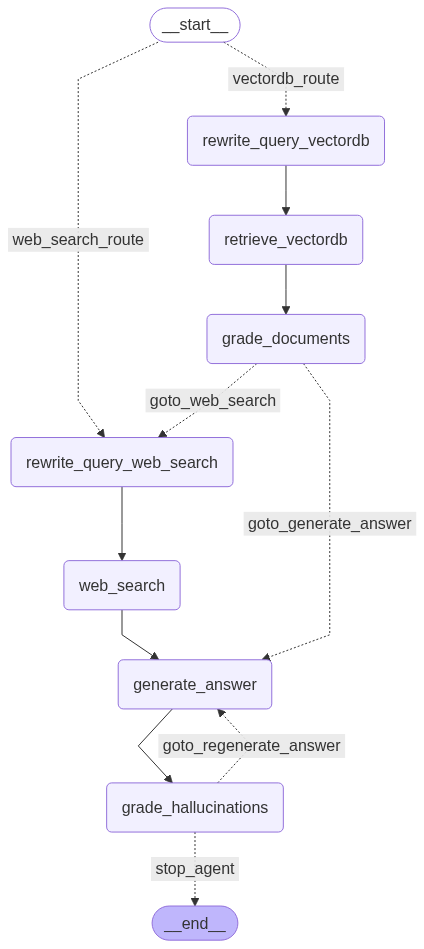

In [51]:
from IPython.display import Image, display, Markdown

display(Image(adaptive_rag.get_graph().draw_mermaid_png()))

## Test the Agentic Adaptive RAG System

### Test Vector DB Route

In [52]:
query = "what is cot prompting?"
response = adaptive_rag.invoke({"orig_question": query})

---ROUTE USER QUESTION---
---ROUTE QUESTION TO STANDARD RAG + VECTOR DB WORKFLOW---
---REWRITING USER QUERY FOR OPTIMAL RETRIEVAL FROM VECTOR DB---
---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---MOST DOCUMENTS (100.0%) ARE RELEVANT TO QUESTION - WEB SEARCH NOT NEEDED---
---ASSESS GRADED DOCUMENTS---
---DECISION: RELEVANT DOCUMENTS EXIST, RUN generate_answer NODE---
---GENERATE ANSWER---
---STANDARD RAG FLOW - GENERATING ANSWER---
---CHECK HALLUCINATIONS---
---HALLUCINATION CHECK: SUCCESSFUL - GENERATION IS GROUNDED IN DOCUMENTS---
---ASSESS HALLUCINATION GRADE---
---DECISION: STOP AGENT---


In [53]:
display(Markdown(response['generation']))

Chain-of-Thought (CoT) prompting is a technique used to enhance the reasoning capabilities of large language models. It involves providing the model with a series of intermediate reasoning steps, or a "chain of thought," that lead to the final answer for a given problem. This approach is particularly useful for complex reasoning tasks, such as multi-step math word problems, where it is beneficial to break down the problem into smaller, manageable steps.

The concept is inspired by the way humans solve complicated reasoning tasks by decomposing them into intermediate steps. For example, when solving a math problem, one might first calculate intermediate values before arriving at the final solution. CoT prompting aims to replicate this process in language models by including these intermediate steps in the prompt.

Empirical evaluations have shown that CoT prompting significantly improves the performance of language models on various reasoning tasks, including arithmetic, commonsense, and symbolic reasoning. For instance, in experiments with the PaLM 540B model, CoT prompting achieved state-of-the-art accuracy on the GSM8K benchmark of math word problems, outperforming standard prompting methods.

The key advantage of CoT prompting is that it allows language models to perform reasoning tasks without the need for extensive fine-tuning or large training datasets. Instead, a few examples of input-output pairs with intermediate reasoning steps are provided as exemplars, enabling the model to generalize and solve similar tasks effectively. This method highlights the potential of large language models to learn and perform complex reasoning tasks through natural language data and few-shot learning.

In [54]:
query = "Compare Diffusions models vs GANs"
response = adaptive_rag.invoke({"orig_question": query})

---ROUTE USER QUESTION---
---ROUTE QUESTION TO STANDARD RAG + VECTOR DB WORKFLOW---
---REWRITING USER QUERY FOR OPTIMAL RETRIEVAL FROM VECTOR DB---
---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---MOST DOCUMENTS (100.0%) ARE RELEVANT TO QUESTION - WEB SEARCH NOT NEEDED---
---ASSESS GRADED DOCUMENTS---
---DECISION: RELEVANT DOCUMENTS EXIST, RUN generate_answer NODE---
---GENERATE ANSWER---
---STANDARD RAG FLOW - GENERATING ANSWER---
---CHECK HALLUCINATIONS---
---HALLUCINATION CHECK: SUCCESSFUL - GENERATION IS GROUNDED IN DOCUMENTS---
---ASSESS HALLUCINATION GRADE---
---DECISION: STOP AGENT---


In [55]:
display(Markdown(response['generation']))

Diffusion models and Generative Adversarial Networks (GANs) are two prominent approaches in the field of generative modeling, each with its own strengths and weaknesses.

**Diffusion Models:**

1. **Mechanism**: Diffusion models generate samples by reversing a gradual noising process. They start with a noisy sample and iteratively refine it to produce a clean image. This process is akin to denoising, where each step reduces the noise level in the sample.

2. **Sample Quality**: Recent advancements have shown that diffusion models can achieve superior image sample quality compared to GANs. For instance, they have achieved impressive Fréchet Inception Distance (FID) scores on datasets like ImageNet, indicating high-quality image generation.

3. **Training and Scalability**: Diffusion models have a stationary training objective, which makes them easier to train and scale compared to GANs. They are less prone to issues like mode collapse, which is a common problem in GANs.

4. **Diversity vs. Fidelity**: Diffusion models can trade off diversity for fidelity using techniques like classifier guidance. This allows them to maintain high fidelity while covering a broader distribution of the data.

5. **Sampling Speed**: A notable drawback of diffusion models is their slower sampling speed due to the multiple denoising steps required. However, techniques are being developed to reduce this gap.

**GANs:**

1. **Mechanism**: GANs consist of two neural networks, a generator and a discriminator, that are trained simultaneously. The generator creates samples, while the discriminator evaluates them against real data, pushing the generator to improve.

2. **Sample Quality**: GANs have historically been the state-of-the-art for image generation tasks, producing high-fidelity images. They are particularly effective at generating sharp and realistic images.

3. **Training Challenges**: GANs are notoriously difficult to train. They require careful tuning of hyperparameters and are susceptible to issues like mode collapse, where the generator produces limited diversity in its outputs.

4. **Diversity vs. Fidelity**: GANs can trade off diversity for fidelity using techniques like the truncation trick, where the latent space is sampled from a truncated distribution to improve image quality at the cost of diversity.

5. **Sampling Speed**: GANs are generally faster at sampling compared to diffusion models, as they do not require iterative refinement steps.

In summary, while GANs have been the traditional choice for high-quality image generation, diffusion models are emerging as a strong alternative, offering better distribution coverage and easier training. However, diffusion models still face challenges in sampling speed, which is an area of active research.

In [56]:
query = "Compare attention methods in transformer in detail"
response = adaptive_rag.invoke({"orig_question": query})

---ROUTE USER QUESTION---
---ROUTE QUESTION TO STANDARD RAG + VECTOR DB WORKFLOW---
---REWRITING USER QUERY FOR OPTIMAL RETRIEVAL FROM VECTOR DB---
---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---MOST DOCUMENTS (80.0%) ARE RELEVANT TO QUESTION - WEB SEARCH NOT NEEDED---
---ASSESS GRADED DOCUMENTS---
---DECISION: RELEVANT DOCUMENTS EXIST, RUN generate_answer NODE---
---GENERATE ANSWER---
---STANDARD RAG FLOW - GENERATING ANSWER---
---CHECK HALLUCINATIONS---
---HALLUCINATION CHECK: SUCCESSFUL - GENERATION IS GROUNDED IN DOCUMENTS---
---ASSESS HALLUCINATION GRADE---
---DECISION: STOP AGENT---


In [57]:
display(Markdown(response['generation']))

The Transformer model, introduced by Vaswani et al. in "Attention Is All You Need," is a groundbreaking architecture that relies entirely on attention mechanisms, specifically self-attention, to process input and output sequences. This approach eliminates the need for recurrent or convolutional neural networks, which were traditionally used in sequence transduction models.

### Attention Mechanisms in Transformers

1. **Self-Attention**:
   - **Definition**: Self-attention, or intra-attention, is a mechanism that relates different positions of a single sequence to compute a representation of the sequence.
   - **Functionality**: It allows the model to weigh the importance of different words in a sequence when encoding a particular word. This is crucial for capturing dependencies regardless of their distance in the sequence.
   - **Advantages**: Self-attention enables parallelization, as it does not rely on sequential processing like RNNs. This significantly speeds up training and inference.

2. **Multi-Head Attention**:
   - **Concept**: Instead of having a single attention mechanism, the Transformer uses multiple attention heads. Each head learns different aspects of the input data.
   - **Implementation**: The input is linearly projected into multiple smaller dimensions, and attention is applied in parallel across these projections. The outputs are then concatenated and linearly transformed.
   - **Benefits**: Multi-head attention allows the model to focus on different parts of the input sequence simultaneously, enhancing its ability to capture complex patterns and relationships.

3. **Scaled Dot-Product Attention**:
   - **Mechanism**: This is the core operation in the attention mechanism, where the dot products of the query with all keys are computed, scaled by the square root of the dimension of the keys, and passed through a softmax function to obtain the weights on the values.
   - **Purpose**: The scaling factor helps in stabilizing the gradients during training, especially when the dimensionality of the keys is large.

### Encoder and Decoder Stacks

- **Encoder**: Consists of a stack of identical layers, each with two sub-layers: a multi-head self-attention mechanism and a position-wise fully connected feed-forward network. Residual connections and layer normalization are applied around each sub-layer.
  
- **Decoder**: Similar to the encoder but includes an additional third sub-layer for multi-head attention over the encoder's output. It also incorporates masking in the self-attention sub-layer to prevent positions from attending to subsequent positions, ensuring that predictions for a position depend only on known outputs.

### Advantages of Transformer Attention Mechanisms

- **Parallelization**: Unlike RNNs, Transformers allow for parallel processing of data, which significantly reduces training time.
- **Long-Range Dependencies**: The attention mechanism can capture dependencies between distant positions in the sequence, which is challenging for RNNs.
- **Scalability**: The architecture can be scaled by increasing the number of attention heads or layers, allowing it to handle more complex tasks.

In summary, the attention mechanisms in Transformers, particularly self-attention and multi-head attention, provide a powerful and efficient way to model sequence data, leading to superior performance in tasks like machine translation and beyond.

In [58]:
query = "Compare LoRA vs QLoRa vs Prompt Tuning in PEFT"
response = adaptive_rag.invoke({"orig_question": query})

---ROUTE USER QUESTION---


---ROUTE QUESTION TO STANDARD RAG + VECTOR DB WORKFLOW---
---REWRITING USER QUERY FOR OPTIMAL RETRIEVAL FROM VECTOR DB---
---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---SEVERAL DOCUMENTS (60.0%) ARE NOT RELEVANT TO QUESTION - WEB SEARCH NEEDED---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, RUN rewrite_query_web_search NODE---
---REWRITING USER QUERY FOR OPTIMAL RETRIEVAL FOR WEB SEARCH---
---WEB SEARCH---
---GENERATE ANSWER---
---STANDARD RAG FLOW - GENERATING ANSWER---


RateLimitError: Error code: 429 - {'error': {'message': 'Request too large for gpt-4o in organization org-S87Jqg5ocbUr83IVDwKuwC46 on tokens per min (TPM): Limit 30000, Requested 63974. The input or output tokens must be reduced in order to run successfully. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

In [ ]:
display(Markdown(response['generation']))

LoRA, QLoRA, and Prompt Tuning are all techniques under the umbrella of Parameter Efficient Fine-Tuning (PEFT) methods, which aim to fine-tune large language models efficiently by reducing the number of trainable parameters. Here's a comparison of these techniques:

1. **LoRA (Low-Rank Adaptation):**
   - **Approach:** LoRA introduces low-rank matrices to approximate the weight updates needed during fine-tuning. Instead of updating the full weight matrix, LoRA updates two smaller matrices, which are then used to compute the weight updates.
   - **Efficiency:** This method significantly reduces the number of trainable parameters, making it more memory and compute-efficient compared to full fine-tuning.
   - **Use Case:** LoRA is particularly useful when the task requires significant changes to the model's behavior, as it allows for more substantial updates than prompt-based methods.

2. **QLoRA (Quantized Low-Rank Adaptation):**
   - **Approach:** QLoRA builds on LoRA by incorporating quantization techniques. It uses 4-bit quantization for the model weights, further reducing memory usage while maintaining performance.
   - **Efficiency:** QLoRA allows for fine-tuning large models on hardware with limited memory, such as a single GPU, by reducing the precision of the weights.
   - **Use Case:** Ideal for scenarios where memory resources are constrained, and the model needs to be fine-tuned on large datasets or tasks.

3. **Prompt Tuning:**
   - **Approach:** Prompt Tuning involves optimizing a set of continuous prompt tokens that are prepended to the input. These tokens are learned during fine-tuning and help guide the model's responses.
   - **Efficiency:** This method is highly parameter-efficient as it only involves learning a small number of additional parameters (the prompt tokens).
   - **Use Case:** Best suited for tasks where the model's existing capabilities are sufficient, and the main challenge is to guide the model's output more effectively through optimized prompts.

**Comparison:**
- **Parameter Efficiency:** Prompt Tuning is the most parameter-efficient, as it only involves learning a few prompt tokens. LoRA and QLoRA involve more parameters but still significantly fewer than full fine-tuning.
- **Memory Usage:** QLoRA is the most memory-efficient due to its use of quantization, making it suitable for very large models.
- **Task Adaptability:** LoRA and QLoRA are better suited for tasks that require substantial model adaptation, while Prompt Tuning is ideal for tasks where the model's existing knowledge is largely sufficient.

In summary, the choice between these methods depends on the specific requirements of the task, the available computational resources, and the degree of model adaptation needed.

In [ ]:
response

{'orig_question': 'Compare LoRA vs QLoRa vs Prompt Tuning in PEFT',
 'rephrased_question': 'LoRA vs QLoRa vs Prompt Tuning in PEFT comparison',
 'generation': "LoRA, QLoRA, and Prompt Tuning are all techniques under the umbrella of Parameter Efficient Fine-Tuning (PEFT) methods, which aim to fine-tune large language models efficiently by reducing the number of trainable parameters. Here's a comparison of these techniques:\n\n1. **LoRA (Low-Rank Adaptation):**\n   - **Approach:** LoRA introduces low-rank matrices to approximate the weight updates needed during fine-tuning. Instead of updating the full weight matrix, LoRA updates two smaller matrices, which are then used to compute the weight updates.\n   - **Efficiency:** This method significantly reduces the number of trainable parameters, making it more memory and compute-efficient compared to full fine-tuning.\n   - **Use Case:** LoRA is particularly useful when the task requires significant changes to the model's behavior, as it all

### Test Web Search Route

In [ ]:
query = "Give a detailed explanation of the various design patterns for Agentic AI Systems"
response = adaptive_rag.invoke({"orig_question": query})

---ROUTE USER QUESTION---
---ROUTING QUESTION TO WEB SEARCH WORKFLOW---
---REWRITING USER QUERY FOR OPTIMAL RETRIEVAL FOR WEB SEARCH---
---WEB SEARCH---
---GENERATE ANSWER---
---STANDARD RAG FLOW - GENERATING ANSWER---
---CHECK HALLUCINATIONS---
---HALLUCINATION CHECK: SUCCESSFUL - GENERATION IS GROUNDED IN DOCUMENTS---
---ASSESS HALLUCINATION GRADE---
---DECISION: STOP AGENT---


In [ ]:
display(Markdown(response['generation']))

The context provided outlines four key design patterns for Agentic AI systems, which are designed to make AI models, particularly large language models (LLMs), more autonomous and capable of handling complex tasks. These patterns are:

1. **Reflection Pattern**: This pattern enhances an AI's ability to self-evaluate and refine its outputs. It involves the AI reviewing its own work, identifying errors or areas for improvement, and iteratively refining its responses. This is particularly useful for tasks requiring precision, such as content creation or code generation. An example of this is the SELF-RAG framework, which integrates retrieval and self-reflection to improve the quality and factual accuracy of language models.

2. **Tool Use Pattern**: This pattern allows AI systems to interact with external tools and resources, expanding their problem-solving capabilities beyond their internal knowledge. For instance, an AI might use web searches, databases, or programming languages like Python to gather information or perform complex computations. This pattern is powerful for tackling tasks that require external data or specialized computations.

3. **Planning Pattern**: This pattern enables AI to break down complex tasks into smaller, manageable steps, creating a strategic roadmap for task completion. It involves outlining objectives, analyzing resources, and executing plans step-by-step. Variations like ReAct (Reasoning and Acting) and ReWOO (Reasoning With Open Ontology) incorporate decision-making and adaptive strategies, allowing AI to dynamically adjust plans based on new information.

4. **Multi-Agent Pattern**: This pattern involves orchestrating multiple AI agents to work collaboratively on complex tasks. Each agent may specialize in different aspects of a task, and they communicate and coordinate to achieve a unified outcome. This pattern is akin to project management in human teams, where different team members handle specific roles but work towards a common goal.

These design patterns collectively enhance the autonomy and efficiency of AI systems, enabling them to perform tasks, make decisions, and interact with other systems in a more human-like manner. They provide a foundation for building intelligent, autonomous AI systems capable of addressing real-world challenges.

### Test Hallucination Handling

Now we will simulate a hallucination occurence by uncommenting a part of the `generate_answer` node function and hard-code a wrong answer to the below question

![](https://i.imgur.com/LkC8oOB.png)

Remember to rerun the agent graph compilation code in 'Build the Agent Graph' section before running the below code

In [66]:
query = "Give a detailed explanation of the various design patterns for Agentic AI Systems"
response = adaptive_rag.invoke({"orig_question": query})

---ROUTE USER QUESTION---
---ROUTING QUESTION TO WEB SEARCH WORKFLOW---
---REWRITING USER QUERY FOR OPTIMAL RETRIEVAL FOR WEB SEARCH---
---WEB SEARCH---
---GENERATE ANSWER---
---STANDARD RAG FLOW - GENERATING ANSWER---
---CHECK HALLUCINATIONS---
---HALLUCINATION CHECK: UNSUCCESSFUL - GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRYING RESPONSE GENERATION---
---ASSESS HALLUCINATION GRADE---
---DECISION: HALLUCINATION EXISTS RERUNNING generate_answer NODE with hallucination_feedback---
---GENERATE ANSWER---
Hallucination Check Feedback: The LLM generated response mentions the observer and factory pattern as the main design patterns, which is not supported by the context documents. The context documents focus on Agentic AI Design Patterns, specifically Reflection, Tool Use, Planning, and Multi-Agent Collaboration, and do not mention the observer or factory patterns.
---REFLECTING ON HALLUCINATED FEEDBACK - GENERATING ANSWER---
---CHECK HALLUCINATIONS---
---HALLUCINATION CHECK: SUCCESSFUL -

In [67]:
display(Markdown(response['generation']))

Agentic AI systems are designed to operate autonomously, mimicking human-like problem-solving and decision-making processes. These systems are structured using specific design patterns that enhance their autonomy and efficiency. The key Agentic AI design patterns include:

1. **Reflection Pattern**: This pattern focuses on the AI's ability to self-evaluate and refine its outputs. The AI system reviews its actions or decisions, identifies errors or areas for improvement, and iteratively refines its approach. This is akin to a human reviewing their work to improve accuracy and reliability. For example, a trading bot might analyze its daily performance, identify underperforming strategies, and adjust its algorithms for better results.

2. **Tool Use Pattern**: This pattern allows AI systems to extend their capabilities by interacting with external tools and resources. Instead of relying solely on internal computations, the AI can access databases, perform web searches, or execute complex functions using programming languages like Python. This pattern is powerful for tasks that require information or computations beyond the AI's pre-existing data, making the system more versatile and applicable to real-world scenarios.

3. **Planning Pattern**: The Planning Pattern enables AI systems to break down complex tasks into smaller, manageable steps. The AI creates a roadmap of subtasks, determining the most efficient path to achieve a goal. This pattern incorporates strategic thinking, allowing the AI to dynamically adapt its workflows based on goals and constraints. Variations like ReAct (Reasoning and Acting) and ReWOO (Reasoning With Open Ontology) further enhance this pattern by integrating decision-making and contextual reasoning.

4. **Multi-Agent Pattern**: This pattern involves orchestrating multiple AI agents to work collaboratively on complex tasks. Each agent is assigned specific roles or functions, and they communicate and collaborate to achieve a unified outcome. This pattern mirrors human teamwork, where different specialists contribute their expertise to solve a problem. It is particularly useful for large-scale or complex problems that require diverse skill sets.

These design patterns collectively enable Agentic AI systems to operate more independently and effectively, pushing the boundaries of what AI can achieve by encouraging self-evaluation, tool integration, strategic planning, and collaboration. By mastering these patterns, developers can create more intelligent, autonomous AI systems capable of addressing real-world challenges.